In [1]:
import sys
IN_COLAB = "google.colab" in sys.modules
IN_JUPYTER = "jupyter_client" in sys.modules

if IN_COLAB:
  !apt install python-opengl
  !apt install ffmpeg
  !apt install xvfb
  !pip install gym==0.21
  !pip install PyVirtualDisplay==3.0
  !pip install Box2D
  !pip install pyglet

  from pyvirtualdisplay import Display
  
  # Start virtual display
  dis = Display(visible=0, size=(400, 400))
  dis.start()

In [2]:
import os
import random
from typing import Dict, List, Tuple

import gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from IPython.display import clear_output
from collections import deque

if (IN_COLAB or IN_JUPYTER) and not os.path.exists("segment_tree.py"):
    # download segment tree module
    !wget https://raw.githubusercontent.com/curt-park/rainbow-is-all-you-need/master/segment_tree.py
        
from segment_tree import MinSegmentTree, SumSegmentTree

### ReplayBuffer

In [3]:
class ReplayBuffer:

    def __init__(self, obs_dim: int, size: int, batch_size: int = 32):
        self.obs_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.next_obs_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.acts_buf = np.zeros([size], dtype=np.float32)
        self.rews_buf = np.zeros([size], dtype=np.float32)
        self.done_buf = np.zeros(size, dtype=np.float32)
        self.max_size, self.batch_size = size, batch_size
        self.ptr, self.size, = 0, 0

    def store(
        self,
        obs: np.ndarray,
        act: np.ndarray, 
        rew: float, 
        next_obs: np.ndarray, 
        done: bool,
    ):
        self.obs_buf[self.ptr] = obs
        self.next_obs_buf[self.ptr] = next_obs
        self.acts_buf[self.ptr] = act
        self.rews_buf[self.ptr] = rew
        self.done_buf[self.ptr] = done
        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

    def sample_batch(self) -> Dict[str, np.ndarray]:
        idxs = np.random.choice(self.size, size=self.batch_size, replace=False)
        return dict(obs=self.obs_buf[idxs],
                    next_obs=self.next_obs_buf[idxs],
                    acts=self.acts_buf[idxs],
                    rews=self.rews_buf[idxs],
                    done=self.done_buf[idxs])

    def __len__(self) -> int:
        return self.size

### Network

In [4]:
class Network(nn.Module):
    def __init__(self, in_dim: int = 8, out_dim: int = 4):
        """Initialization."""
        super(Network, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(in_dim, 64), 
            nn.ReLU(),
            nn.Linear(64, 64), 
            nn.ReLU(), 
            nn.Linear(64, out_dim)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward method implementation."""
        return self.layers(x)

In [5]:
class DQNAgent:
    def __init__(
        self,
        env: gym.Env,
        memory_size: int,
        batch_size: int,
        target_update: int,       # frequency for target model's synchronization
        epsilon_decay: float,
        max_epsilon: float = 1.0,
        min_epsilon: float = 0.01,
        gamma: float = 0.99, 
    ):
        obs_dim = env.observation_space.shape[0]
        action_dim = env.action_space.n

        self.env = env
        self.memory = ReplayBuffer(obs_dim, memory_size, batch_size)
        self.batch_size = batch_size
        self.epsilon = max_epsilon
        self.epsilon_decay = epsilon_decay
        self.max_epsilon = max_epsilon
        self.min_epsilon = min_epsilon
        self.target_update = target_update
        self.gamma = gamma
        self.learning_rate = 5e-4
        self.max_step = 700

        self.device = torch.device(
            "cuda" if torch.cuda.is_available() else "cpu"
        )
        print(self.device)
        

        self.dqn = Network(obs_dim, action_dim).to(self.device)
        self.dqn_target = Network(obs_dim, action_dim).to(self.device)
        self.dqn_target.load_state_dict(self.dqn.state_dict())
        self.dqn_target.eval()

        # opitmizer
        self.optimizer = optim.Adam(self.dqn.parameters(), lr=self.learning_rate)
        self.transition = list()

    def select_action(self, state: np.ndarray) -> np.ndarray:
        if self.epsilon > np.random.random():
            selected_action = self.env.action_space.sample()
        else:
            selected_action = self.dqn(
                torch.FloatTensor(state).to(self.device)
            ).argmax()
            selected_action = selected_action.detach().cpu().numpy()
        
        if not self.is_test:
            self.transition = [state, selected_action]
        
        return selected_action

    def step(self, action: np.ndarray) -> Tuple[np.ndarray, np.float64, bool]:
        next_state, reward, done, _ = self.env.step(action)
        # self.env.render()

        if not self.is_test:
            self.transition += [reward, next_state, done]
            self.memory.store(*self.transition)
    
        return next_state, reward, done

    def update_model(self) -> torch.Tensor:
        samples = self.memory.sample_batch()

        loss = self._compute_dqn_loss(samples)

        self.optimizer.zero_grad()    
        loss.backward()
        self.optimizer.step()

        return loss.item()

    def train(self, episodes: int = 1000, plotting_interval: int = 200):
      self.is_test = False

      state = self.env.reset()
      update_cnt = 0
      step_cnt = 0
      epsilons = []
      losses = []
      scores = []
      scores_window = deque(maxlen=100)
      score = 0

      for episode in range(1, episodes + 1):

        self.epsilon = max(self.min_epsilon, self.epsilon * self.epsilon_decay)
        epsilons.append(self.epsilon)

        for s in range(self.max_step):
          step_cnt += 1
          action = self.select_action(state)
          next_state, reward, done = self.step(action)

          state = next_state
          score += reward


          if len(self.memory) >= self.batch_size:
            loss = self.update_model()
            losses.append(loss)
            update_cnt += 1
            
            
            if update_cnt % self.target_update == 0:
              self._target_hard_update()

          
          if done:
            state = self.env.reset()
            scores.append(score)
            scores_window.append(score)
            score = 0
            break

        # if episode % 100 == 0:
        #   self._plot(step_cnt, scores, losses, epsilons)

        print('\rEpisode {}\tAverage Score: {:.2f}'.format(episode, np.mean(scores_window)), end="")
        if episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(episode, np.mean(scores_window)))
        if episode == episodes:
            self._plot(scores)
              
      self.env.close()

    
    def test(self, video_folder: str) -> None:
        self.is_test = True

        naive_env = self.env
        self.env = gym.wrappers.RecordVideo(self.env, video_folder=video_folder)

        state = self.env.reset()
        done = False
        score = 0

        while not done:
            action = self.select_action(state)
            next_state, reward, done = self.step(action)

            state = next_state
            score += reward

        print("score: ", score)
        self.env.close()

        self.env = naive_env


    def _compute_dqn_loss(self, samples: Dict[str, np.ndarray]) -> torch.Tensor:
        device = self.device
        state = torch.FloatTensor(samples["obs"]).to(device)
        next_state = torch.FloatTensor(samples["next_obs"]).to(device)
        action = torch.LongTensor(samples["acts"].reshape(-1, 1)).to(device)
        reward = torch.FloatTensor(samples["rews"].reshape(-1, 1)).to(device)
        done = torch.FloatTensor(samples["done"].reshape(-1, 1)).to(device)

        cur_q = self.dqn(state).gather(1, action)
        next_q = self.dqn_target(next_state).max(dim=1, keepdim=True)[0].detach()
        mask = 1 - done
        target_q = (reward + self.gamma * mask * next_q).to(self.device)

        loss = F.mse_loss(cur_q, target_q)

        return loss


    def _target_hard_update(self):
        self.dqn_target.load_state_dict(self.dqn.state_dict())

    def _plot(
        self, 
        scores: List[float], 
    ):
        # clear_output(True)
        plt.figure(figsize=(10, 7))
        plt.xlabel("Episode")
        plt.ylabel("Score")
        plt.plot(scores)
        plt.ylim(-400,350)
        plt.show()

                

In [6]:
env_id = "LunarLander-v2"
env = gym.make(env_id)

In [7]:
seed = 777

def seed_torch(seed):
    torch.manual_seed(seed)
    if torch.backends.cudnn.enabled:
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

np.random.seed(seed)
seed_torch(seed)
env.seed(seed)

[777]

In [8]:
# parameters
episodes = 1000
memory_size = 30000
batch_size = 64
target_update = 200
epsilon_decay = 0.995

agent = DQNAgent(env, memory_size, batch_size, target_update, epsilon_decay)

cpu


### Train

Episode 100	Average Score: -109.89
Episode 200	Average Score: -64.384
Episode 300	Average Score: 32.840
Episode 400	Average Score: 190.67
Episode 500	Average Score: 186.67
Episode 600	Average Score: 200.36
Episode 700	Average Score: 237.54
Episode 800	Average Score: 210.35
Episode 900	Average Score: 238.50
Episode 1000	Average Score: 226.91


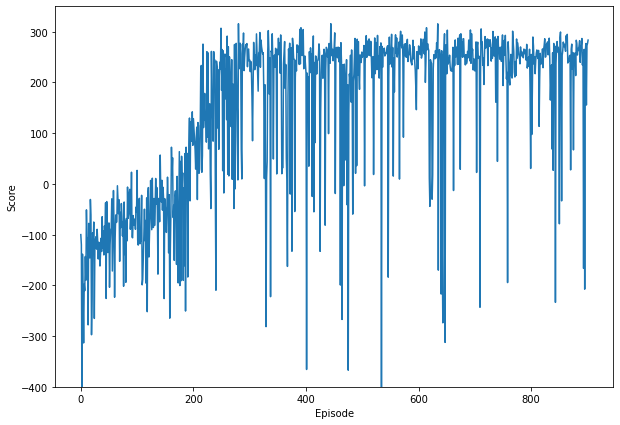

In [9]:
agent.train(episodes)